# Run QSVR experiments with multiple splits

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from qa_summer.QSVR import QSVR
from dimod import ExactSolver
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from utils import nb_utils
from joblib import dump, load
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime
from random import randint, random
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import neal #import to use simulated annealing sampler
from dwave.system import LazyFixedEmbeddingComposite, DWaveSampler #import to select specific sampler
from dwave.system import VirtualGraphComposite
from scipy.stats import loguniform

In [42]:
search_svr_hps = False
experiment_name = ''
save = True
#date = datetime.datetime.now().strftime("_%Y_%m_%d-%I:%M:%S.%f_%p")
#experiment_name = experiment_name + date

### Run experiments with fixed epsilon, C and gamma

In [43]:
'''
WARNING: THIS CELL SENDS PROBLEMS TO D-WAVE MULTIPLE TIMES
REMEMBRER D-WAVE AVALIABLE TIME IS LIMITED
'''
if search_svr_hps: #ONLY RUNS FOR FIXED SVR PARAMS: epsilon, C and gamma
	nb_utils.exit_cell('Exiting cell as search_svr_hps is set to True')

# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

rs = randint(0, 2**30)
num_runs = 10
r2 = np.zeros((num_runs, 7))
qsvr_model = QSVR.QSVR() # instantiate outside to reuse embedding and afford time
for i in range(num_runs):
	# train test split
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=rs+i)
	X_train = X_train[:79,:]
	y_train = y_train[:79]
	
	# QSVR code
	#qsvr_model = QSVR.QSVR() # instantiate moved outside the loop
	#RUN ON D-WAVE
	#set sampler
	#sampler = LazyFixedEmbeddingComposite(DWaveSampler(region='na-west-1', solver='Advantage_system6.1'))
	#sampler = neal.SimulatedAnnealingSampler()
	#sampler = VirtualGraphComposite(DWaveSampler()) 
	qsvr_model.fit(X_train, y_train,
			K = 3, B = 0.5,
			epsilon = 0.02, k0 = 0.005,
			xi=0.01, n_samples = 20,
			#num_reads = 5000,
			num_reads=1000,
			random_seed=rs+i,
			n_samples_for_gamma_and_C_optimizations=40,
			gamma=0.1, C=67.61,
			use_custom_chainstrength=True,
			chain_mult=10,
			#sampler=sampler,
			result_percentage_used = 0.004
		)
	
	if save: nb_utils.save_qsvr(qsvr_model, 'qsvr_attrs_'+experiment_name+'_rs'+str(rs)+'_i'+str(i)) # save QSVR for further predictions
	
	# evaluate QSVR
	y_pred = qsvr_model.predict(X_test)
	for j in range(7):
		r2[i,j] = r2_score(y_pred[j],y_test)
	print(f'Finished run {i} with r2 = {r2[i,:]} with mean = {r2[i,:].mean()}')

results = {
	'scores norm' : r2[:,0],
	'scores softmax' : r2[:,1],
	'scores lc norm' : r2[:,2],
	'scores lc softmax' : r2[:,3],
	'best set of alphas' : r2[:,4],
	'simple mean' : r2[:,5],
	'min energy' : r2[:,6]
}

if save: dump(results, 'results_'+experiment_name+'_rs'+str(rs)+'.joblib')

for k in results.keys():
	print(f'{k}: {results[k]}')

Exiting cell as search_svr_hps is set to True


### Run experiments searching for epsilon, C and gamma

In [31]:
'''
WARNING: THIS CELL SENDS PROBLEMS TO D-WAVE MULTIPLE TIMES
REMEMBRER D-WAVE AVALIABLE TIME IS LIMITED
'''
if not search_svr_hps: #ONLY RUNS if user wants to search for: epsilon, C and gamma
	nb_utils.exit_cell('Exiting cell as search_svr_hps is set to False')
	
# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

rs = randint(0, 2**30)
num_runs = 0
r2 = np.zeros((num_runs, 7))
for i in range(num_runs):
	# train test split
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=rs+i)

	# Optimiza SVR hps using classical SVR
	best, C_best, epsilon_best, gamma_best = -100, None, None, None
	for j in range(5000):
		#C = loguniform.rvs(1e0,1e3)
		C = loguniform.rvs(5.0,1e3) # after experiment this range seems probably better for qsvr 
		#gamma = loguniform.rvs(1e-5,10)
		gamma = loguniform.rvs(0.01,10) # after experiment this range seems probably better for qsvr 
		#epsilon = loguniform.rvs(1e-3,1e0)
		epsilon = loguniform.rvs(1e-3,0.4) # after experiment this range seems probably better for qsvr 
		model = SVR(C=C,epsilon=epsilon,gamma=gamma)
		cvs, __ = nb_utils.small_train_r2_cv(model, X=X_train, y=y_train, train_size= 20, reps=5, test_size=0.74,rs=rs+j)
		cvs = cvs.mean()
		if best < cvs:
			best = cvs
		C_best, epsilon_best, gamma_best = C, epsilon, gamma
	
	B = 0.5
	K = 3
	k0 = 0.005
	exponents_array = np.array(list(range(K)))
	exponents_array = exponents_array-k0
	C_min = sum(np.power(B, exponents_array))
	
	if (C_best < C_min): 
		C_best = C_min
			
	print(pd.DataFrame({'CV mean R^2': best, 'C': C_best, 'epsilon': epsilon_best, 'gamma': gamma_best}, index=['Best hyperparameters']))

	X_train, _, y_train, _ = train_test_split(X, y, train_size=20, random_state=rs+i)

	# QSVR code
	qsvr_model = QSVR.QSVR() # instantiate
	#RUN ON D-WAVE
	#set sampler
	sampler = LazyFixedEmbeddingComposite(DWaveSampler(region='na-west-1', solver='Advantage_system6.1'))
	qsvr_model.fit(X_train, y_train,
			K = K, B = B,
			epsilon = epsilon_best, k0 = k0,
			xi=0.01, n_samples = 20, num_reads = 1000,
			random_seed=rs+i,
			n_samples_for_gamma_and_C_optimizations=0,
			gamma=gamma_best, C=C_best,
			use_custom_chainstrength=True,
			chain_mult=8,
			sampler=sampler)
	
	if save: nb_utils.save_qsvr(qsvr_model, 'qsvr_attrs_'+experiment_name+'_rs'+str(rs)+'_i'+str(i)) # save QSVR for further predictions
	# evaluate QSVR
	y_pred = qsvr_model.predict(X_test)
	for j in range(7):
		r2[i,j] = r2_score(y_pred[j],y_test)
	print(f'Finished run {i} with r2 = {r2[i,:]}')
results = {
	'scores norm' : r2[:,0],
	'scores softmax' : r2[:,1],
	'scores lc norm' : r2[:,2],
	'scores lc softmax' : r2[:,3],
	'best set of alphas' : r2[:,4],
	'simple mean' : r2[:,5]
}

if save: dump(results, 'results_'+experiment_name+'_rs'+str(rs)+'.joblib')

for k in results.keys():
	print(f'{k}: {results[k]}')

Exiting cell as search_svr_hps is set to False


## Analize experiment results

In [23]:
# uncomment following line(s) if you want to analize results of a saved experiment
#results = load('../results/good_qsvr/chain_str_10/results_eric_params_chain_10_hp_search_rs965737426.joblib')
#sufix = '_eric_params_chain_10_hp_search_rs965737426'
#folder_path = '../results/good_qsvr/chain_str_10/'
#rs = 965737426

### Summary R^2 Table

In [7]:
summary = pd.DataFrame(columns = ['method', 'min', 'max', 'mean', 'median', 'std'])
for k in results.keys():
    summary.loc[len(summary.index)] =[k,
        results[k].min(),
        results[k].max(),
        results[k].mean(),
        np.median(results[k]),
        results[k].std()]
summary

,method,min,max,mean,median,std
0,scores norm,0.641861,0.948413,0.865821,0.894811,0.086095
1,scores softmax,0.760638,0.946151,0.878661,0.893369,0.054855
2,scores lc norm,0.640308,0.948421,0.865287,0.894510,0.086750
3,scores lc softmax,0.742472,0.948311,0.880937,0.896780,0.056134
4,best set of alphas,0.761256,0.946151,0.876103,0.892239,0.056913
5,simple mean,-0.701135,0.897623,0.658647,0.866834,0.470536
6,min energy,0.735379,0.915576,0.845504,0.852980,0.057063


### Plot

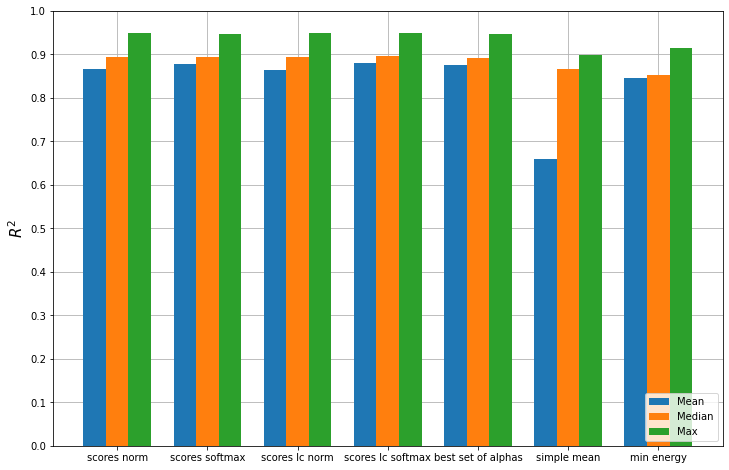

In [40]:
barWidth = 0.25

fig = plt.subplots(figsize =(12, 8))
plt.grid()
plt.gca().set_axisbelow(True)
 
# set height of bar
#MIN = [val.min() for val in results.values()]
MEAN = [val.mean() for val in results.values()]
MEDIAN = [np.median(val) for val in results.values()]
MAX = [val.max() for val in results.values()]
 
# Set position of bar on X axis
br1 = np.arange(len(results))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, MEAN, width = barWidth, label ='Mean')
plt.bar(br2, MEDIAN, width = barWidth, label ='Median')
plt.bar(br3, MAX, width = barWidth, label ='Max')

# Adding Xticks
plt.ylabel('$R^2$', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(results.keys()))], list(results.keys()))
plt.yticks(np.arange(0, 1.1, 0.1))

plt.legend(loc = 'lower right')
plt.show()

### Generate a data frame with the SVR hps and the R^2 values

In [22]:
# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data: May Need to load an Scaler if a different one was used for the original experiment
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

info = pd.DataFrame(columns = ['epsilon', 'C', 'gamma', 'scores norm', 'scores softmax', 'scores lc norm', 'scores lc softmax', 'best set of alphas', 'simple mean', 'min energy', 'mean'])
for i in range(10):
    ld_qsvr_attrs = load(folder_path+"qsvr_attrs"+sufix+"_i"+str(i)+".joblib")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=rs+i)

    epsilon = ld_qsvr_attrs["epsilon"]
    gamma = ld_qsvr_attrs["best_gamma"]
    C = ld_qsvr_attrs["best_C"]
    row = [epsilon, C, gamma]

    pred_model = QSVR.QSVR() 
    
    # set the QSVR attributes needed for predictions
    for attr in ld_qsvr_attrs.keys():
        setattr(pred_model, attr, ld_qsvr_attrs[attr])


    # use the QSVR to do a prediction
    # loaded scalers may be needed
    y_pred = pred_model.predict(X_test)

    # make use of the prediction
    r2s = []
    for i in range(y_pred.shape[0]):
        r2s.append(r2_score(y_pred[i],y_test))

    row.extend(r2s)
    row.append(np.array(r2s).mean())

    info.loc[len(info.index)] = row

info

,epsilon,C,gamma,scores norm,scores softmax,scores lc norm,scores lc softmax,best set of alphas,simple mean,min energy,mean
0,0.02,67.61,0.1,0.918006,0.915989,0.918008,0.917845,0.915989,0.829528,0.839459,0.893546
1,0.02,67.61,0.1,0.908366,0.900612,0.908368,0.900904,0.900612,0.900653,0.896475,0.902284
2,0.02,67.61,0.1,0.898760,0.896701,0.898709,0.896369,0.896701,0.843065,0.896701,0.889572
3,0.02,67.61,0.1,0.928713,0.929741,0.928320,0.933365,0.926246,0.765396,0.930929,0.906101
4,0.02,67.61,0.1,0.900754,0.872377,0.900723,0.872460,0.872377,0.903456,0.855438,0.882512
5,0.02,67.61,0.1,0.866953,0.816396,0.866395,0.869525,0.800899,0.851678,0.859950,0.847399
6,0.02,67.61,0.1,0.563372,0.721390,0.561123,0.705410,0.721576,0.313343,0.721576,0.615399
7,0.02,67.61,0.1,0.912116,0.901188,0.912134,0.910170,0.899850,0.901138,0.855820,0.898917
8,0.02,67.61,0.1,0.786106,0.887513,0.783153,0.856561,0.886101,-0.793957,0.706098,0.587368
9,0.02,67.61,0.1,0.936158,0.940654,0.936253,0.941027,0.940654,0.887655,0.846170,0.918367


### Redo an experiment now using simulated annealing

In [24]:
# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data: May Need to load an Scaler if a different one was used for the original experiment
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

annealed_info = pd.DataFrame(columns = ['epsilon', 'C', 'gamma', 'scores norm', 'scores softmax', 'scores lc norm', 'scores lc softmax', 'best set of alphas', 'simple mean', 'min energy', 'mean'])
for i in range(10):
	load(folder_path+"qsvr_attrs"+sufix+"_i"+str(i)+".joblib")
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=rs+i)
	X_train, _, y_train, _ = train_test_split(X, y, train_size=20, random_state=rs+i)

	epsilon = ld_qsvr_attrs["epsilon"]
	gamma = ld_qsvr_attrs["best_gamma"]
	C = ld_qsvr_attrs["best_C"]
	row = [epsilon, C, gamma]
	B = 0.5
	K = 3
	k0 = 0.005

	# QSVR code
	qsvr_model = QSVR.QSVR() # instantiate
	#RUN ON D-WAVE
	#set sampler
	sampler = neal.SimulatedAnnealingSampler()
	qsvr_model.fit(X_train, y_train,
			K = K, B = B,
			epsilon = epsilon, k0 = k0,
			xi=0.01, n_samples = 20, num_reads = 1000,
			random_seed=rs+i,
			n_samples_for_gamma_and_C_optimizations=0,
			gamma=gamma, C=C,
			use_custom_chainstrength=True,
			chain_mult=8,
			sampler=sampler)

	# use the QSVR to do a prediction
	# loaded scalers may be needed
	y_pred = pred_model.predict(X_test)

	# make use of the prediction
	r2s = []
	for i in range(y_pred.shape[0]):
		r2s.append(r2_score(y_pred[i],y_test))

	row.extend(r2s)
	row.append(np.array(r2s).mean())

	annealed_info.loc[len(annealed_info.index)] = row

annealed_info

Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
no field of name chain_break_fraction
->trying with: result = rfn.merge_arrays((unique_samples, unique_records["energy"], unique_counts))
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
